# How to use functions in unityvr.analysis?

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
from scipy.stats import vonmises, skew, kurtosis
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from unityvr.preproc import logproc as lp
from unityvr.viz import viz
from unityvr.analysis import posAnalysis, shapeAnalysis, fitting, utils

## Constructing unityvr data object from log file

Unity logs the experiment in a `.json` file (example provided in the sample folder). If the experiment is being done along with 2p imaging using ScanImage, refer to sample2pAnalysis.ipynb for alignment. There are two ways to close the loop in unity with fictrac: 
- `FictracSubject.cs`: relies on integrating rotation values supplied by fictrac to derive the animal's heading in unity
- `FictracSubjectIntegrated.cs`: while the other relies on using the integrated heading values from fictrac itself

Refer to [janelia-unity-toolkit](https://github.com/JaneliaSciComp/janelia-unity-toolkit/tree/master/org.janelia.collision-handling) for this. 

In [2]:
dirName = '../sample/sample18'
fileName = 'Log_2025-01-13_16-11-35_trial_fictrac_late.json'
fileName

'Log_2025-01-13_16-11-35_trial_fictrac_late.json'

In [3]:
uvrTest = lp.constructUnityVRexperiment(dirName, fileName, fictracSubject='Not Integrated', posDfKey = 'attemptedTranslation')
#if using FictracSubjectIntegrated, set fictracSubject='Integrated' and posDfKey = 'worldPosition'
#posDfKey specifies the string that will be matched to find the chunk in the json that contains position data. For FictracSubjectIntegrated this is expected to be 'worldPosition', while for FictracSubject it is expected to be 'attemptedTranslation'.
uvrTest.printMetadata()

correcting for Unity angle convention.
Metadata:

expid  :  SS96-x-7f_dark
experiment  :  holder V2, closed loop panorama, 144 Hz frame rate, collected by Shivam
genotype  :  SS96-x-7f
sex  :  female
flyid  :  f03
trial  :  trialate
date  :  2025-01-13
time  :  16-11-35
ballRad  :  0.04699999839067459
translationalGain  :  1.0
setFrameRate  :  144
notes  :  EB
temperature  :  Room
angle_convention  :  right-handed


# Trajectory Analysis

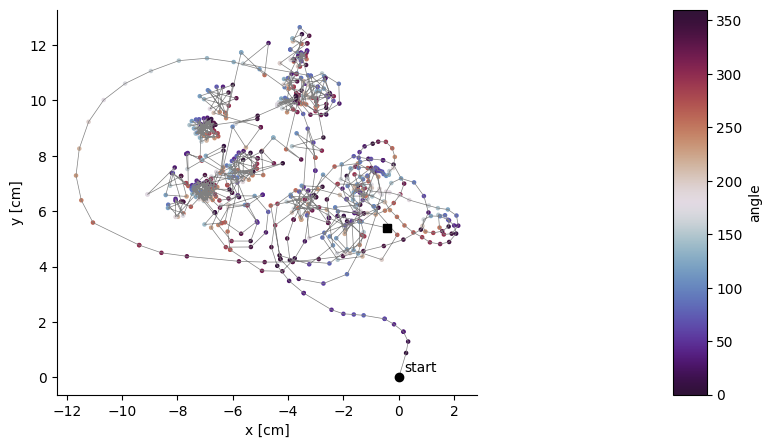

In [4]:
#use position function to generate position dataframe and plot trajecotory
#rotate_by parameter rotates the trajectory, in this example by 90 degrees
#the rotation gets updated in the metadata, 
#any subsequent rotation will modify the trajectory as well as the metadata
posDf = posAnalysis.position(uvrTest, 
                             derive = False, #derive set to true adds 
                             #derived parameters like velocity and angle to the dataframe
                             rotate_by=None, #in degrees if cylinder worlds have no offset applied: ensures that the darkest part of the world is at 0°
                             plot=True,
                             computeVel=True,
                             #pass the following parameters to save the dataframe in a chosen directory
                             #,plotsave=False,saveDir=saveDir         
                            )

In [5]:
# The metadata is automatically extended:
uvrTest.printMetadata()
#IMPORTANT: this is because the uvrTest object is updated in place by the position function

Metadata:

expid  :  SS96-x-7f_dark
experiment  :  holder V2, closed loop panorama, 144 Hz frame rate, collected by Shivam
genotype  :  SS96-x-7f
sex  :  female
flyid  :  f03
trial  :  trialate
date  :  2025-01-13
time  :  16-11-35
ballRad  :  0.04699999839067459
translationalGain  :  1.0
setFrameRate  :  144
notes  :  EB
temperature  :  Room
angle_convention  :  right-handed


## Testing Fictrac-Unity Interface


### Fictrac integration

Get file `.dat` file from fictrac. Look at the `deltaRotationVectorLab` (see the [fictrac header](https://github.com/rjdmoore/fictrac/blob/master/doc/data_header.txt)). 

In [10]:
fictracData = pd.read_csv('../sample/sample18/fictrac-20250113_161140.dat', header= None).iloc[:,[5,6,7,14,15,16,24]].rename(columns={5:'dx',6:'dy',7:'dz',14:'x',15:'y',16:'angle',24:'time'})
fictracData['time'] = (fictracData.iloc[:,-1] - fictracData.iloc[0,-1])/1e3 # convert to seconds

In [11]:
fictracData.head()

,dx,dy,dz,x,y,angle,time
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.040695,0.014944,-0.154069,0.018015,-0.039388,0.154069,0.006118
2,0.341524,-0.017084,0.014560,0.051066,-0.379735,0.139509,0.012869
3,0.589652,0.033996,0.163978,0.118833,-0.965841,6.258716,0.019677
4,0.951713,0.238200,0.042105,0.313464,-1.927342,6.216611,0.026679


Check that integrating fictrac `dz` gives the integrated angle reported by fictrac. Note that the integration is done by [negating the angular change](https://www.sciencedirect.com/science/article/pii/S0165027014000211?via%3Dihub):

$$

\Theta^k = \Theta^{k-1} - \omega_z

$$

$k$ is a given video frame.

In [14]:
fictracData['integrated_dz'] = np.cumsum(-fictracData['dz'].values)%(2*np.pi)

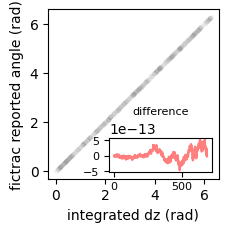

In [47]:
fig, ax = plt.subplots(figsize = (2.2,2.2))
ax.plot(fictracData['integrated_dz'], fictracData['angle'], 'k.', alpha=0.01);
ax.set_xlabel('integrated dz (rad)')
ax.set_ylabel('fictrac reported angle (rad)');

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
ax_inset = inset_axes(ax, width="60%", height="20%", loc="lower right")  # Adjust size and position
ax_inset.plot(fictracData['angle']-fictracData['integrated_dz'], color="red", alpha=0.5)
ax_inset.set_title("difference", fontsize=8)
ax_inset.tick_params(axis='both', which='major', labelsize=8)


Similarly integrate the x and y components of the velocity to get the x and y components of the position. Then, compare this with fictrac's reported x and y positions.

The integration is performed in the following way: 

$$
\begin{bmatrix} 
x \\ 
y 
\end{bmatrix}^k 

= 
\begin{bmatrix} 
x \\ 
y 
\end{bmatrix}^{k-1} 

+ 

\begin{bmatrix} 
\cos^{k}\theta & -\sin^{k}\theta \\ 
\sin^{k}\theta & \cos^{k}\theta 
\end{bmatrix} 
\cdot 
\begin{bmatrix} 
\omega_y \\ 
-\omega_x 
\end{bmatrix}

$$

Note that $x^k$ depends on $x^{k-1}, \omega_x, \omega_y$ and $\Theta^k$. This means than an error in any of these values will propagate.

In [133]:
def compute_xy(wx_series, wy_series, theta_k_series, initial_Px, initial_Py):
    
    n = len(wx_series)
    Px_series = np.zeros(n)
    Py_series = np.zeros(n)

    # Set initial values
    Px_series[0] = initial_Px
    Py_series[0] = initial_Py

    # Iterate through the time series
    for k in range(0, n):
        # Rotation matrix for time step k
        rotation_matrix = np.array([
            [np.cos(theta_k_series[k]), -np.sin(theta_k_series[k])],
            [np.sin(theta_k_series[k]),  np.cos(theta_k_series[k])]
        ])
        
        # Vector involving wx and wy
        omega_vector = np.array([wy_series[k], -wx_series[k]])
        
        # Perform the transformation
        result_vector = np.matmul(rotation_matrix, omega_vector)
        
        # Add the previous term to the transformed vector
        Px_series[k] = Px_series[k - 1] + result_vector[0]
        Py_series[k] = Py_series[k - 1] + result_vector[1]
    
    return Px_series, Py_series

Perform the calculation for fictrac values: 

In [134]:
# full fictrac calculation
fictracData['integrated_x'],fictracData['integrated_y'] = compute_xy(fictracData['dx'], fictracData['dy'], fictracData['integrated_dz'], 0.0, 0.0)

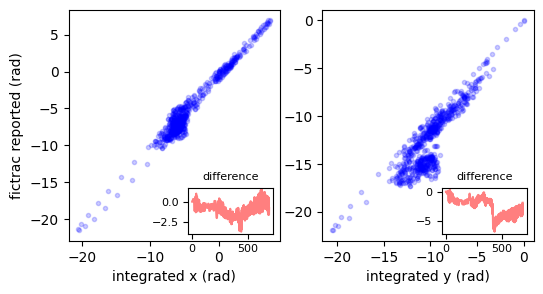

In [135]:
fig, ax = plt.subplots(1,2,figsize = (6,3))
for d, dim_str in enumerate(['x', 'y']):
    ax[d].plot(fictracData['integrated_'+dim_str], fictracData[dim_str], 'b.', alpha=0.2);
    ax[d].set_xlabel(f'integrated {dim_str} (rad)')
    if d<1: ax[d].set_ylabel(f'fictrac reported (rad)');

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ax_inset = inset_axes(ax[d], width="40%", height="20%", loc="lower right")  # Adjust size and position
    ax_inset.plot(fictracData[dim_str]-fictracData['integrated_'+dim_str], color="red", alpha=0.5)
    ax_inset.set_title("difference", fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

Show fictrac trajectory and integrated trajectory:

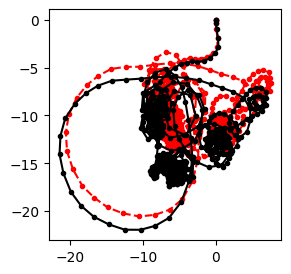

In [137]:
plt.figure(figsize=(3,3))
plt.plot(fictracData['integrated_x'], fictracData['integrated_y'],'r.--');   
plt.plot(fictracData['x'], fictracData['y'], 'k.-');

Why is it different from what the reported integrated estimate?  

## Are unity and fictrac values equivalent? 

Unity logs fictrac values if required (check log fictrac box). These fictrac values can be compared to the fictrac values in the data file. 

In [153]:
unityDf = pd.merge(posDf, uvrTest.ftDf, on='frame', how='right', suffixes=('_unity', '_fictrac')).rename(columns={'dz':'dz_fictrac'})

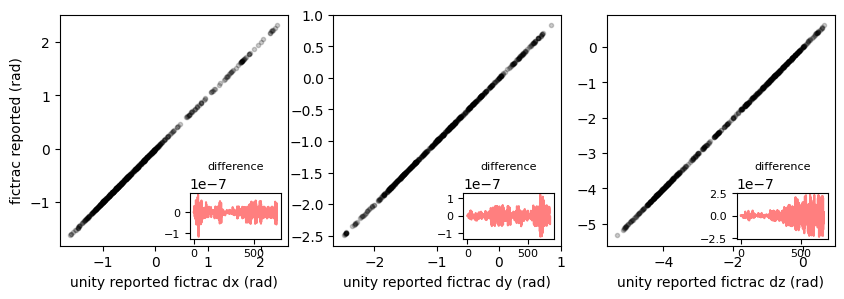

In [156]:
fig, ax = plt.subplots(1,3,figsize = (10,3))
for d, dim_str in enumerate(['dx', 'dy', 'dz']):
    ax[d].plot(unityDf[dim_str+'_fictrac'], fictracData[dim_str], 'k.', alpha=0.2);
    ax[d].set_xlabel(f'unity reported fictrac {dim_str} (rad)')
    if d<1: ax[d].set_ylabel(f'fictrac reported (rad)');

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ax_inset = inset_axes(ax[d], width="40%", height="20%", loc="lower right")  # Adjust size and position
    ax_inset.plot(unityDf[dim_str+'_fictrac']-fictracData[dim_str], color="red", alpha=0.5)
    ax_inset.set_title("difference", fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

### Is unity and fictrac integration equivalent? 
Does integrating unity reported fictrac values give the same outcome as unity x and y? 

In [167]:
# full unity calculation (naive)
unityDf['integrated_z'] = np.cumsum(-unityDf['dz_fictrac'].values)%(2*np.pi)
unityDf['integrated_x'],unityDf['integrated_y'] = compute_xy(unityDf['dx_fictrac'], unityDf['dy_fictrac'], unityDf['integrated_z'], 0.0, 0.0)

unityDf['rescaled_x'] = unityDf['x']/uvrTest.metadata['ballRad']
unityDf['rescaled_y'] = -unityDf['y']/uvrTest.metadata['ballRad']

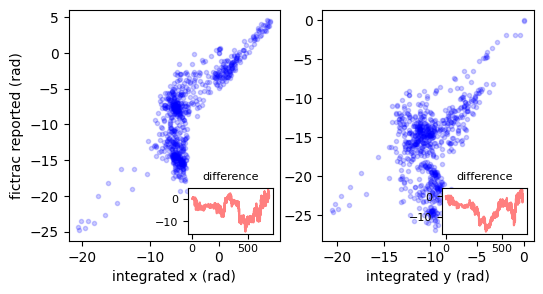

In [168]:
fig, ax = plt.subplots(1,2,figsize = (6,3))
for d, dim_str in enumerate(['x', 'y']):
    ax[d].plot(unityDf['integrated_'+dim_str], unityDf['rescaled_'+dim_str], 'b.', alpha=0.2);
    ax[d].set_xlabel(f'integrated {dim_str} (rad)')
    if d<1: ax[d].set_ylabel(f'fictrac reported (rad)');

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ax_inset = inset_axes(ax[d], width="40%", height="20%", loc="lower right")  # Adjust size and position
    ax_inset.plot(unityDf['rescaled_'+dim_str]-unityDf['integrated_'+dim_str], color="red", alpha=0.5)
    ax_inset.set_title("difference", fontsize=8)
    ax_inset.tick_params(axis='both', which='major', labelsize=8)

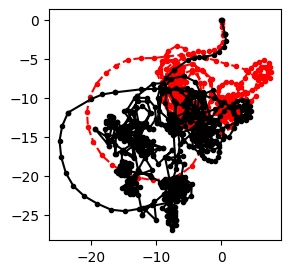

In [169]:
plt.figure(figsize=(3,3))
plt.plot(unityDf['integrated_x'], unityDf['integrated_y'],'r.--');   
plt.plot(unityDf['rescaled_x'], unityDf['rescaled_y'], 'k.-');

Why? 

## Tracing the source of the following differences:

1. Why is fictrac's integration not what seems to be reported in the paper? 
 - floating point errors? 
 - difference in sampling rate? 

2. Why is unity's integration not the same as the integration procedure reported in the fictrac paper? 
- difference in update rate of fictrac vs. unity?